In [1]:
#Load libraries
import pandas as pd
import numpy as np
import os,warnings
warnings.filterwarnings('ignore')
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Set up plotting parameters
color_discrete={'H0001':"#686ae7",'A0001':"#913c0b",'A0002':'#b24a0e',
                'A0003':'#e55f12','A0004':'#ff8742',
                'A0005':'#ffb489'}
gene_order=['PB2','PB1','PA','HA','NP','NS']
sampeorder=['A0001','A0002','A0003','A0004','A0005','H0001']
sample_labels={'A1':'A0001','A2':'A0002','A3':'A0003','A4':'A0004','A5':'A0005','H1':'H0001'}

### 1. Load and process data

In [3]:

file=('../data/concatenated_snps.tsv')
data = pd.read_table(file)
aa_codons = data[['sample','POS','gene','REF_CODON','ALT_CODON','TOTAL_DP','ALT_FREQ','PVAL',
                  'ALT_DP','POS_AA','REF_AA','ALT_AA','REF_DP', 'ALT_RV']]
aa_codons.loc[:,'ALT_FREQ'] = aa_codons['ALT_FREQ'].round(2)
aa_codons.loc[:,'aminoacid_change'] = aa_codons['REF_AA'] + aa_codons['POS_AA'].astype(int).astype(str) + \
                                        aa_codons['ALT_AA']
aa_codons.loc[:,'ALT_Depth'] = round(aa_codons['ALT_FREQ'] * aa_codons['TOTAL_DP'])
aa_codons['sample'] = aa_codons['sample'].map(sample_labels)


### 2. Set up alterations

In [4]:

aa = data[['POS','gene','REF_CODON','REF_AA','ALT_CODON','ALT_AA','POS_AA','sample']]
aa['mutation'] = aa['REF_AA'] +'>' + aa['ALT_AA']
df = aa[['POS_AA','gene','REF_AA','ALT_AA','sample']]
df['sample'] = df['sample'].map(sample_labels)

#drop where 'REF_AA' is same as 'ALT_AA'
df = df[ df['REF_AA'] != df['ALT_AA'] ]

In [5]:
df['mutation_id'] = (df['gene'] + ':' + df['REF_AA'] + df['POS_AA'].\
                     astype(int).astype(str) +df['ALT_AA'])

#Since the 591 appears in pig and a human lets manually replace
df['mutation_id'] = df['mutation_id'].str.replace('PA:*591Q', 'PA:Q591*')
df.sort_values(by='POS_AA', inplace=True)
incidence = (df.assign(present=True).pivot_table(
                        index='mutation_id',columns='sample',values='present',fill_value=False))
incidence = incidence.astype(bool)

#order by gene and numbering
gene_rank = {g: i for i, g in enumerate(gene_order)}

def mutation_sort_key(idx):
    gene = idx.str.split(':').str[0]
    pos = (idx.str.split(':').str[1] .str[1:-1].astype(int))
    return gene.map(gene_rank).fillna(len(gene_order)) * 1_000_000 + pos

#sort the incidence dataframe
incidence = incidence.sort_index(key=mutation_sort_key)


### 4. Generate figuers from the dataset

<Figure size 300x400 with 0 Axes>

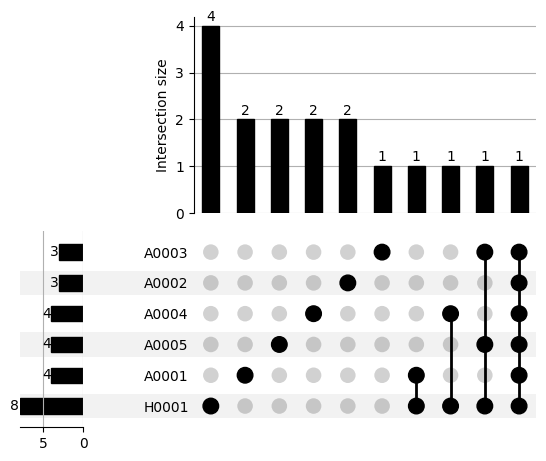

In [7]:
plt.figure(figsize=(3,4))
upset_data = from_indicators(incidence.columns, incidence)
UpSet(upset_data,subset_size='count',show_counts=True,sort_by='degree').plot()

plt.tight_layout()
outdir='../figure'
plt.savefig(os.path.join(outdir,'Figure_S3A.pdf'))
# plt.close()
plt.show()

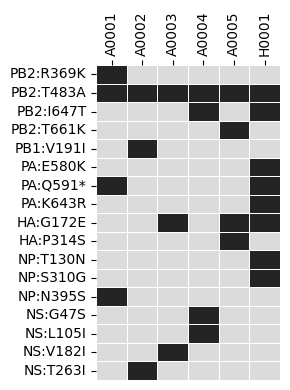

In [8]:

plt.figure(figsize=(3,4))
ax = sns.heatmap(
    incidence.astype(int),
    cmap=sns.color_palette(palette='binary'),cbar=False,
    yticklabels=incidence.index, linewidths=0.5,linecolor='white'
)
ax.set(ylabel='',xlabel='') #Variant Mutation
ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=90)
plt.tight_layout()
plt.savefig(os.path.join(outdir,'Figure_S3B.pdf'))
